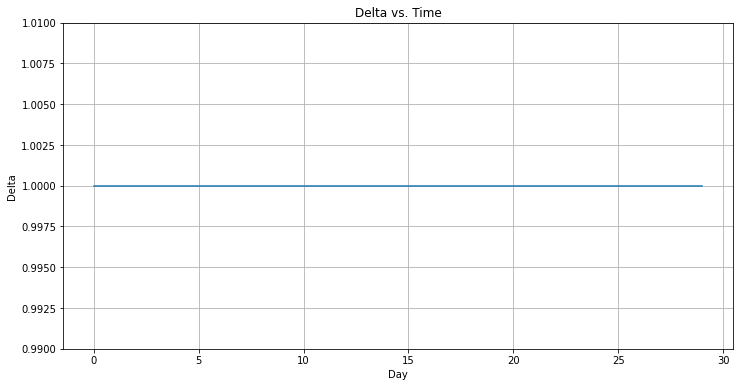

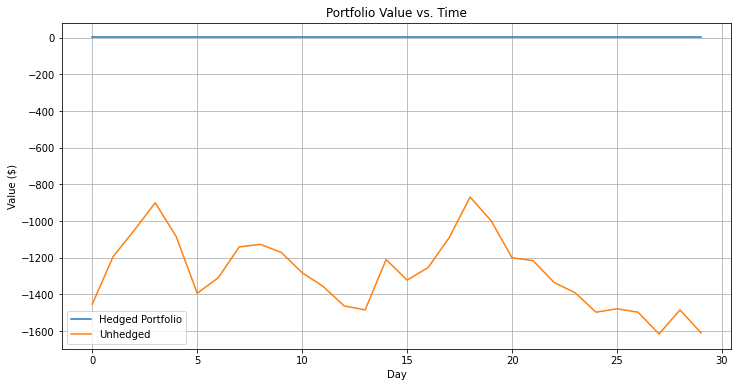

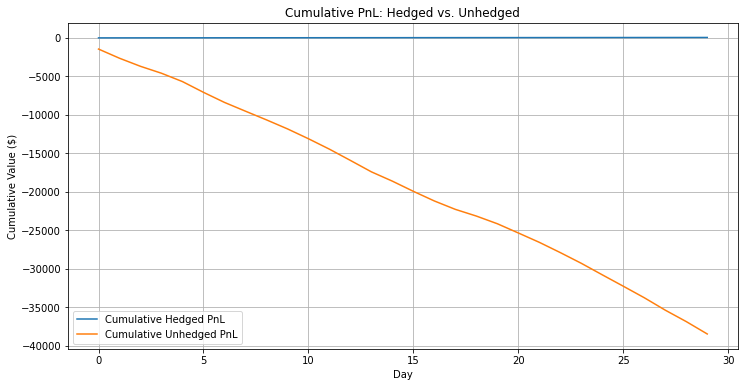

In [15]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Black-Scholes Call Delta
def bs_delta(curr_price, strike_price, T, r, sigma):
    # T: time to expiration (% of year)
    # r: continuously compounded risk-free interest rate
    # sigma: volatility
    d1 = (np.log(curr_price / strike_price) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Black–Scholes Formula for Call Option Price
def bs_call_price(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price
    
# Initialize variables
data = pd.read_csv('oracle.csv', parse_dates=['Date'])
data = data.iloc[1263:1303] # Restrict dates from 2000-01-03 to 2000-02-29
data = data.reset_index(drop=True)
expiry_days = 30
r = 0.01
sigma = 0.2
option_size = 100


# Function for trading simulation, with customizable strike price
def simulate(data, strike):
    # Initialize tracking variables
    hedged_shares = 0
    hedged_cash = 0
    hedged_portfolio_value = []
    baseline_portfolio_value = []
    deltas = []
    days = []
    
    # Add premium on day 0 using Black-Scholes
    S0 = data.loc[0, 'Close']
    T0 = expiry_days / 252
    premium = bs_call_price(S0, strike, T0, r, sigma) * option_size
    hedged_cash += premium 

    # Run simulation
    for day in range(min(expiry_days, len(data))):
            
        S = data.loc[day, 'Close']
        T = (expiry_days - day) / 252
        delta = bs_delta(S, strike, T, r, sigma)
        target_shares = delta * option_size
    
        # Adjust hedge
        share_diff = target_shares - hedged_shares
        hedged_cash -= share_diff * S
        hedged_shares = target_shares
    
        # Find value of hedged portfolio
        call_liability = max(S - strike, 0) * option_size # call_liability = current intrinsic value of the call option
        hedged_value = hedged_shares * S + hedged_cash - call_liability
        baseline_value = -call_liability # baseline_value assumes no hedge
    
        # Append results
        hedged_portfolio_value.append(hedged_value)
        baseline_portfolio_value.append(baseline_value)
        deltas.append(delta)
        days.append(day)
    
    results_df = pd.DataFrame({
        'Day': days,
        'Delta': deltas,
        'Hedged Value': hedged_portfolio_value,
        'Unhedged Value': baseline_portfolio_value
    })
    return results_df

# Run simulation with strike price = 15
results_df = simulate(data, 15)

# Plot generation
plt.figure(figsize=(12, 6))
plt.plot(results_df['Day'], results_df['Delta'])
plt.title("Delta vs. Time")
plt.xlabel("Day")
plt.ylabel("Delta")
plt.ylim(0.99, 1.01)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(results_df['Day'], results_df['Hedged Value'], label="Hedged Portfolio")
plt.plot(results_df['Day'], results_df['Unhedged Value'], label="Unhedged")
plt.title("Portfolio Value vs. Time")
plt.xlabel("Day")
plt.ylabel("Value ($)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(results_df['Day'], np.cumsum(results_df['Hedged Value']), label="Cumulative Hedged PnL")
plt.plot(results_df['Day'], np.cumsum(results_df['Unhedged Value']), label="Cumulative Unhedged PnL")
plt.title("Cumulative PnL: Hedged vs. Unhedged")
plt.xlabel("Day")
plt.ylabel("Cumulative Value ($)")
plt.legend()
plt.grid(True)
plt.show()


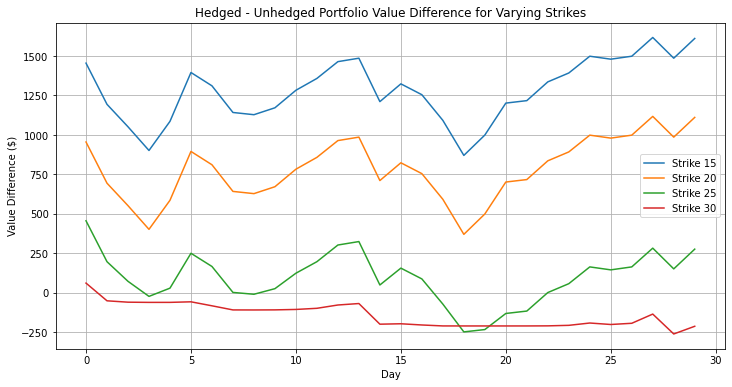

In [13]:
# Plot the difference between hedged and unhedged portfolio values for each strike price
strike_prices = [15, 20, 25, 30]
plt.figure(figsize=(12, 6))

for strike in strike_prices:
    hedged = simulate(data, strike)['Hedged Value']
    unhedged = simulate(data, strike)['Baseline Value']
    difference = [h - u for h, u in zip(hedged, unhedged)]
    plt.plot(range(len(difference)), difference, label=f"Strike {strike}")

plt.title("Hedged - Unhedged Portfolio Value Difference for Varying Strikes")
plt.xlabel("Day")
plt.ylabel("Value Difference ($)")
plt.legend()
plt.grid(True)
plt.show()
